# Neural Networks for Eddy Covarinace

In [6]:
## Import some standard packages and define a few functions
import os
# Hide default info, logs, and warnings - comment out if you need to troubleshoot
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import shutil
import importlib
import numpy as np
import pandas as pd
# from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
# from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs

dbNames = {
    'Clean/SecondStage/TA_1_1_1':'T air',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/NETRAD_1_1_1':'Rn',
    'Clean/SecondStage/P_1_1_1':'Precip',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'u*',
    'Clean/SecondStage/TS_1':'T soil 5cm',
    'Clean/SecondStage/TS_2':'T soil 10cm',
    'Clean/SecondStage/TS_3':'T soil 50cm',
    'Clean/SecondStage/wind_speed':'Wind speed',
    'Clean/SecondStage/wind_dir':'Wind dir',
    'Clean/SecondStage/WTD_1_1_1':'Water table',
}

Local = '/mnt/c/Users/User/PostDoc_Work/database/'
Remote = '/mnt/w/'

Dir = Local

Site = 'BB'

read_new = True
if read_new == True:
    Data = ReadDB.get_Traces(Site,list(dbNames.keys()),Dir=Dir)
    Data = Data.rename(columns=dbNames)
    Data.to_csv(f'temp/{Site}_Data.csv')

else:
    Data = pd.read_csv(f'temp/{Site}_Data.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')



## Pre-processing

In [7]:
importlib.reload(ReadDB)

Data['VPD'] = MiscFuncs.Calc_VPD(Data['T air'],Data['RH'])
Data['Water table'] = -1*(70-Data['Water table'])
Data['DOY'] = Data.index.dayofyear

target = ['FCO2','FCH4']

Data['Rand']=np.random.random(Data['FCO2'].values.shape)
Data['Rand_Binary'] = Data['Rand']-.5
Data['Rand_Skew'] = Data['Rand']**.25
Data.loc[Data['Rand_Binary']>0,'Rand_Binary']=1
Data.loc[Data['Rand_Binary']<0,'Rand_Binary']=-1
Rand_Scalars=['Rand','Rand_Binary','Rand_Skew']

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.dir_mask('Wind dir',[[0,45],[315,360]])
filter.rain('Precip',thresh=0)
filter.MAD(z=5)
filter.uStar('u*',u_thresh=0.1)

Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()

print(Data[['FCO2_Clean','FCH4_Clean']].describe())

excludes = ['fco2','fch4','precip']

Full_inputs = []

for val in list(Data.columns):
    exct = 0
    for ex in excludes:
        if ex in val.lower():
            exct += 1
    if exct < 1:
        Full_inputs.append(val)

Full_inputs

               FCO2          FCH4
count  33385.000000  37097.000000
mean      -0.457040     51.854595
std        3.770148     68.253487
min      -45.689865   -198.555832
25%       -1.767280      9.356360
50%       -0.121570     33.294426
75%        0.718945     89.551025
max       49.698837    695.056885
         FCO2_Clean    FCH4_Clean
count  10940.000000  10248.000000
mean      -0.525573     17.851301
std        1.363216     14.280396
min       -2.791655    -47.824982
25%       -1.675785      7.303655
50%       -0.608034     14.886700
75%        0.466262     28.229795
max        2.990116     47.854935


['T air',
 'RH',
 'PPFD',
 'Rn',
 'u*',
 'T soil 5cm',
 'T soil 10cm',
 'T soil 50cm',
 'Wind speed',
 'Wind dir',
 'Water table',
 'VPD',
 'DOY',
 'Rand',
 'Rand_Binary',
 'Rand_Skew']

# Make Scenarios

In [8]:
def Configure_Run(run,name,df,Base='',H=[10],N_scale=1):
    run['config']['Name']=name
    run['config']['Base']=Base

    # Nodes / layer = the number of inputs times a multiplier
    # Defaults to a scaled function of the number of inputs
    Nodes = [h*int(len(run['config']['inputs'])**N_scale) for h in H]
    run['config']['Nodes']=Nodes
    run['config']['Activation']=['relu' for h in H]
    run['config']['epochs']=250

    # Drop_Thresh = RI'^(Prune_scale[0])+Prune_scale[1]
    # RI' is the sum of RI for the random scalar inputs
    run['config']['Prune_scale']=[1,0]
    
    run['config']['Norm']=True
    run['config']['RF_comp']=False
    run['config']['validation_split']=.2
    run['config']['patience']=2
    run['config']['N_models']=10

    run['Training'] = {}
    # run['Evaluation'] = {}

    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    Model_Runs[key]['config']['mean'] = df[inputs].mean().values
    Model_Runs[key]['config']['variance'] = df[inputs].std().values**2
    df = df.loc[df[target+inputs].dropna().index].copy()
    print(df[target+inputs].shape)
    
    Model_Runs[key]['Training']['X'] = df[inputs].values
    Model_Runs[key]['Training']['Y'] = df[target].values.flatten()

    # Larger batch > runs faster > but won't fit as well
    batch = np.ceil(Model_Runs[key]['Training']['Y'].shape[0]*.02)
    if batch<32:
        batch=32
    run['config']['batch_size']=int(batch)

    return(run)    

Model_Runs = {
    'Full_Model_FCH4':{
        'config':{
            'target':['FCH4_Clean'],
            'inputs':Full_inputs,
            'Rand_Scalars':Rand_Scalars,
            },
        },
    'Full_Model_FCO2':{
        'config':{
            'target':['FCO2_Clean'],
            'inputs':Full_inputs,
            'Rand_Scalars':Rand_Scalars,
            },
        },
}

for key in Model_Runs.keys():
    print(key)
    Base = key.split('_')[-1]
    Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),Base=Base)
Model_Runs[key]['config']

Full_Model_FCH4
(10218, 17)
Full_Model_FCO2
(10910, 17)


{'target': ['FCO2_Clean'],
 'inputs': ['T air',
  'RH',
  'PPFD',
  'Rn',
  'u*',
  'T soil 5cm',
  'T soil 10cm',
  'T soil 50cm',
  'Wind speed',
  'Wind dir',
  'Water table',
  'VPD',
  'DOY',
  'Rand',
  'Rand_Binary',
  'Rand_Skew'],
 'Rand_Scalars': ['Rand', 'Rand_Binary', 'Rand_Skew'],
 'Name': 'Full_Model_FCO2',
 'Base': 'FCO2',
 'Nodes': [160],
 'Activation': ['relu'],
 'epochs': 250,
 'Prune_scale': [1, 0],
 'Norm': True,
 'RF_comp': False,
 'validation_split': 0.2,
 'patience': 2,
 'N_models': 10,
 'mean': array([ 1.06816502e+01,  8.42309494e+01,  2.21587738e+02,  8.56802002e+02,
         1.67757392e-01,  1.17176456e+01,  1.15721235e+01,  1.13481674e+01,
         1.53174806e+00,  1.69052139e+02, -8.71550739e-01,  2.80865645e+00,
         1.83143136e+02,  5.00452959e-01,  8.63642289e-04,  8.00291717e-01]),
 'variance': array([4.74444850e+01, 2.40380395e+02, 1.34442042e+05, 8.85799322e+04,
        1.35185358e-02, 2.75859618e+01, 2.57567701e+01, 1.30295913e+01,
        1.34270

## Build and train model

In [9]:
importlib.reload(NNetFuncs)


def Build_Train_Eval(Run,print_sum=False):

    config = Run['config']
    Training = Run['Training']
    
    NNetFuncs.make_Dense_model(config,print_sum=print_sum)
    Eval=NNetFuncs.train_model(config,Training)
    _=NNetFuncs.run_Model(config,Eval)

for Run in Model_Runs.keys():
    print(Run)
    Build_Train_Eval(Model_Runs[Run],print_sum=True)
    print('\n\n')


Full_Model_FCH4
Model: "Full_Model_FCH4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 normalization (Normalizatio  (None, 16)               0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 160)               2720      
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
None
Training Time:
 110.44  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.67134 


# Evaluate and prune the model

In [15]:
importlib.reload(NNetFuncs)

for key in ['Full_Model_FCH4','Full_Model_FCO2']:

    Continue_Prune = 1
    T1 = time.time()
    while Continue_Prune > 0:
        config = Model_Runs[key]['config']
        RI = NNetFuncs.Prune(config,Verbose=True)
        Pruned_Inputs = list(RI.loc[RI['Drop']==0].index)
        print('Inputs: ',Pruned_Inputs,'\n\n')
        if len(Pruned_Inputs)<len(config['inputs'])-len(Rand_Scalars) and len([i for i in Rand_Scalars if i in list(RI.index)]):
            key = f"Pruned_Model_{config['Base']}"
            if len(Pruned_Inputs)<len(Rand_Scalars):
                drop_rand = RI.loc[RI.index.isin(Rand_Scalars)].sort_values(by='RI_bar').index[0]
                config['Rand_Scalars'].remove(drop_rand)
            for r in config['Rand_Scalars']:
                if r not in Pruned_Inputs:
                    Pruned_Inputs.append(r)

            Model_Runs[key]={
                    'config':{
                        'target':config['target'],
                        'inputs':Pruned_Inputs,
                        'Rand_Scalars':Rand_Scalars,
                        },
                    }

            Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),config['Base'])
            print('Re-training on ',Model_Runs[key]['config']['inputs'])
            Build_Train_Eval(Model_Runs[key])
            print()
        else:
            Continue_Prune = 0
            key = f"Final_Model_{config['Base']}"
            Model_Runs[key]={
                    'config':{
                        'target':config['target'],
                        'inputs':Pruned_Inputs
                        },
                    }

            print('Final inputs: ',Model_Runs[key]['config']['inputs'])#[:-1],'\n\n')
            Model_Runs[key] = Configure_Run(Model_Runs[key],key,Data.copy(),config['Base'])
            Model_Runs[key]['config']['N_models']=30
            Model_Runs[key]['config']['patience']=2
            # Build_Train_Eval(Model_Runs[key],print_sum=True)
            # shutil.rmtree(f'Models/{Base}/Pruned_Model')
    T2 = time.time()

    print("Pruning Time: ", T2-T1)

             T air    Rn  Wind dir  PPFD    RH  Rand_Binary  Rand   VPD  \
RI_bar        0.36  0.40      0.55  0.65  0.68         0.86  0.94  1.00   
lower_bound   0.22  0.31      0.51  0.51  0.58         0.78  0.82  0.82   
Drop          3.22  3.22      3.22  3.22  3.22         3.22  3.22  3.22   

             Rand_Skew  T soil 5cm  T soil 10cm    u*  Wind speed   DOY  \
RI_bar            1.42        1.47         1.83  3.14        3.72  4.56   
lower_bound       1.27        1.29         1.48  2.51        3.01  3.13   
Drop              3.22        3.22         3.22  3.22        3.22  3.22   

             Water table  T soil 50cm  
RI_bar              8.68        69.76  
lower_bound         6.88        59.73  
Drop                0.00         0.00  
Inputs:  ['Water table', 'T soil 50cm'] 


(10218, 5)
Re-training on  ['Water table', 'T soil 50cm', 'Rand', 'Rand_Skew']
Training Time:
 309.63  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.62042 
RMSE =  8.67882
Run Ti

In [16]:
for key in ['Final_Model_FCH4','Final_Model_FCO2']:
    Model_Runs[key]['config']['N_models']=30
    Model_Runs[key]['config']['patience']=2
    Build_Train_Eval(Model_Runs[key],print_sum=True)
Model_Runs.keys()

Model: "Final_Model_FCH4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizatio  (None, 2)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Training Time:
 1068.13  Seconds
NN Model
 Validation metrics (ensemble mean): 
r2 =  0.62924 
RMSE =  8.57737
Run 

dict_keys(['Full_Model_FCH4', 'Full_Model_FCO2', 'Pruned_Model_FCH4', 'Final_Model_FCH4', 'Pruned_Model_FCO2', 'Final_Model_FCO2'])

# Inspect pruned model

NN Model
 Validation metrics (ensemble mean): 
r2 =  0.06366 
RMSE =  1.31883
Run Time:
 0.58  Seconds
10 models
Mean epochs/model:  26.5
             RI_bar  RI_CI95
T soil 50cm   100.0    13.39


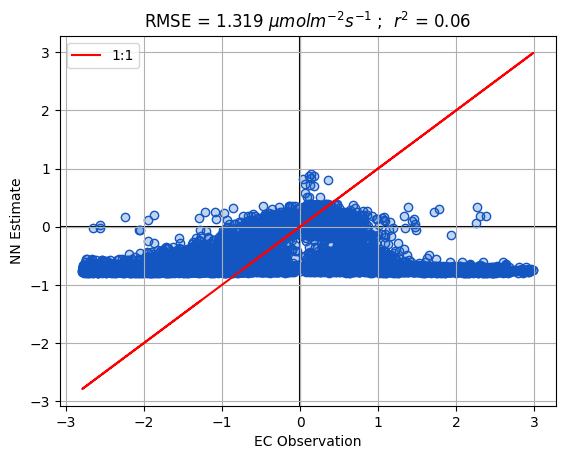

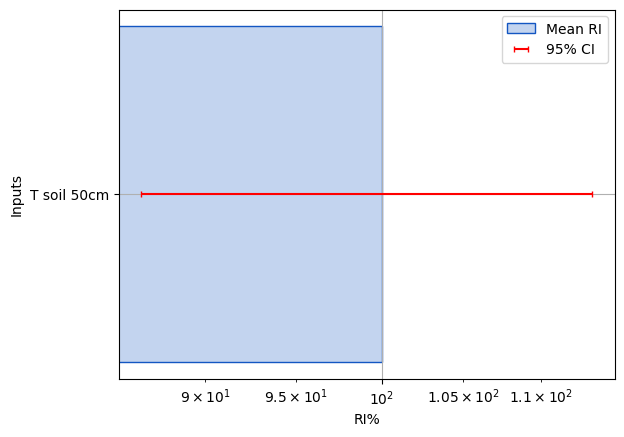

In [ ]:
importlib.reload(PlotHelpers)

key = 'Final_Model_FCH4'

config = Model_Runs[key]['config']
Eval = Model_Runs[key]['Training']
full_out=NNetFuncs.run_Model(config,Eval)
# print('\n\n')

Base = Model_Runs[key]['config']['Base']
Name = Model_Runs[key]['config']['Name']

# run = 'Feature_Detection'
if config['Base']=='FCH4':
    unit = '$nmol m^{-2} s^{-1}$'

else:
    unit = '$\mu mol m^{-2} s^{-1}$'

df = pd.read_csv(f'Models/{Base}/{Name}/model_output.csv',index_col=[0])

fig,ax=plt.subplots()
ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
ax.set_ylabel('NN Estimate')
ax.set_xlabel('EC Observation')
 
RI = pd.read_csv(f'Models/{Base}/{Name}/model_RI.csv',index_col=[0])

RI = RI.sort_values(by=f'RI_bar',ascending=True)
fig,ax=plt.subplots()
PlotHelpers.makeRI_plot(ax,RI)

print(RI.round(2))


In [ ]:
importlib.reload(PlotHelpers)
importlib.reload(MiscFuncs)

Max=6
Top = list(RI.sort_values(by=f'RI_bar',ascending=False).index)

exclude = ['HR']
for ex in exclude:
    try:
        Top.remove(ex)
    except:
        pass

Top = Top[:Max]

cols = 2
npi=len(RI.index)
rows = int(np.ceil(len(Top)/2))

fig,axes=plt.subplots(rows,cols,sharey=True,
                      figsize=(6,6))

axes = axes.flatten()

mod = ''

for i,xi in enumerate(Top):
    print(xi)
    # ax.axvspan(0,0,edgecolor='k',linewidth=1.5)
    df_int = MiscFuncs.byInterval(df,f'{xi}{mod}',[f'dy_d{xi}{mod}'],bins=25)
    PlotHelpers.CI_Plot(axes[i],df_int,f'dy_d{xi}{mod}')
plt.tight_layout()

axes[i].get_ylabel()

for ax in axes:
    l = ax.get_ylabel().split('_norm')[0]
    ax.set_ylabel(l.replace('_',' / ').replace('y','FCO2'))
    ax.set_xlabel(l.split('_d')[-1]+' '+mod.split('_')[-1])
    plt.tight_layout()


In [ ]:

# df = pd.read_csv(f'Models/{run}/random_forest_output.csv',index_col=[0])

# unit = ''

# fig,ax=plt.subplots()
# ax.scatter(df['target'],df['y_bar'])
# ax.plot(df['target'],df['target'],color='k')
# r2 = np.round(metrics.r2_score(df['target'],df['y_bar']),2)
# RMSE = np.round(metrics.mean_squared_error(df['target'],df['y_bar'])**.5,2)
# ax = PlotHelpers.make1_1_Plot(ax,df,'target','y_bar',unit=unit)
# ax.set_ylabel('NN Estimate')
# ax.set_xlabel('EC Observation')

# RF_RI = pd.read_csv(f'Models/{run}/random_forest_RI.csv',index_col=[0])

# mod = ''

# RF_RI = RF_RI.sort_values(by = f'RI{mod}_bar')

# fig,ax=plt.subplots()
# ax.barh(RF_RI.index,RF_RI[f'RI{mod}_bar'],xerr=RF_RI[f'RI{mod}_CI95'])
# ax.grid()
# ax.set_xscale('log')

# RF_RI

In [ ]:
# NN_RI = pd.read_csv(f'{run}/model_RI.csv',index_col=[0])
# mod = '_norm'

# NN_RI = NN_RI.sort_values(by=f'RI{mod}_bar',ascending=True)
# fig,ax=plt.subplots()

# ax.barh(NN_RI.index,NN_RI[f'RI{mod}_bar'],yerr=NN_RI[f'RI{mod}_CI95'])
# ax.grid()


In [ ]:
# RF_Output = pd.read_csv(f'{run}/random_forest_output.csv',index_col=[0])

# RF_Output.head()